# torch.optim: optimization package in PyTorch

In the following notebook, we shall take a closer look at the `torch.optim` package.

The reference documentation for the package is [here](https://pytorch.org/docs/stable/optim.html)

The package typically provides gradient-descent optimization algorithms.

Currently, the following algorithms are available:

- Stochastic Gradient Descent (SGD)
  - with heavy-ball and nesterov momentum variants (optional)
  - with L2 weight decay (optional)
- Adadelta
- Adagrad
- Adam
- SparseAdam
- Adamax
- Averaged SGD
- L-BFGS
- RMSProp
- RProp (resilient backprop)

The optim package is available via `import torch.optim as optim`

It makes no assumption on the function it is optimizing, and treats functions as a blackbox `f(x)`.

The package is designed to work well with neural networks defined using  `torch.nn.Module`, but does not rely on `torch.nn`.


In [0]:
# lets install PyTorch and torchvision
# This cell has to be re-run if the session expires
!pip3 install torch torchvision

# imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

## A walkthrough of the API

The optim package has optimizers placed in two buckets:

(1) The optimizer evaluates f(x) only once
    - examples: SGD, RMSProp, RProp, Adagrad, Adam, etc.
(2) The optimizer evaluates f(x) multiple times, with different `x`
    - example: L-BFGS, evolutionary algorithms


**Case (1): Evaluate-once optimizers**

In the case of (1), when f(x) is evaluated only once, we provide a simple interface that is roughly as follows:

```
y = f(x) # f is the function we are optimizing
x        # params to optimize. a Tensor or list of Tensors with requires_grad=True

# construct an optimizer object
optimizer = optim.SGD(x, lr=0.1, momentum=0.9)

# one gradient-descent step
optimizer.zero_grad()
y = f(x)
y.backward()
optimizer.step()
```

Here's an example of how these optimizers will be used with `nn.Module` based neural networks:

```
model = torchvision.models.resnet18()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for inputs, labels in dataset:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()
```

**Case (2): Optimizer does multiple evaluations of f(x)**

In this case the API is a little more involved. One has to define the function `f(x)` as a python closure, and give that to `optimizer.step`.

For example:

```
for input, target in dataset:
    def closure():
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        return loss
    optimizer.step(closure)
```

## Classifying two-moons dataset using Logistic Regression

Let us work through a small example of classifying the noisy two-moons dataset generated via scikit-learn.

In [0]:
X, y = make_moons(100, shuffle=True, noise=0.1)

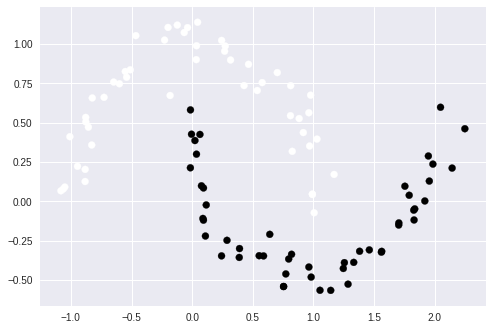

In [147]:
plt.scatter(X[:, 0], X[:, 1], c=y)

The goal is to build a classifier that classifies the white points from the black ones.

Let us create weights and biases for a model `y = sigmoid(W * X + b)`

In [0]:
weight = torch.randn(2, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

X = torch.tensor(X, dtype=torch.float32) # convert from numpy to PyTorch format
y = torch.tensor(y, dtype=torch.float32)

Now, let's create an Stochastic Gradient Descent optimizer that will optimize the weights and biases of the model

In [0]:
optimizer = optim.SGD([weight, bias], lr=0.001)

We shall use the Binary Cross Entropy loss, which implicitly will do the Sigmoid operation to convert the inputs to logits

In [0]:
loss_fn = F.binary_cross_entropy_with_logits

Now, let's train!

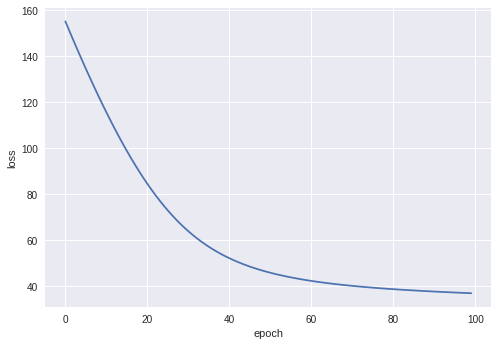

In [151]:
n_epochs = 100
loss_epoch = [0] * n_epochs

for epoch in range(n_epochs): # number of epochs through the dataset
  for i in range(100): # size of dataset
    optimizer.zero_grad()
    y_predicted = torch.dot(X[i], weight) + bias
    loss = loss_fn(y_predicted[0], y[i])
    loss.backward()
    optimizer.step()
  
    loss_epoch[epoch] += loss.item()

plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(loss_epoch)

An interesting exercise would be to see how different optimization algorithms fare in terms of rate of convergence.

Let us construct a few, and plot their losses.


Now, let's construct a new model that is cloned 4 times, along with these optimizers which take each of the 4 cloned models:

- Plain SGD
- SGD with momentum
- RMSProp
- Adam

We clone the model so that all optimizations can start from the same starting weights, for equal comparison.

In [0]:
weight = torch.randn(2, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

params_sgd = [weight.data.clone().requires_grad_(), bias.data.clone().requires_grad_()]
sgd = optim.SGD(params_sgd, lr=0.01)

params_sgdmom = [weight.data.clone().requires_grad_(), bias.data.clone().requires_grad_()]
sgdmom = optim.SGD(params_sgdmom, lr=0.01, momentum=0.5)

params_rms = [weight.data.clone().requires_grad_(), bias.data.clone().requires_grad_()]
rms = optim.RMSprop(params_rms, lr=0.01)

params_adam = [weight.data.clone().requires_grad_(), bias.data.clone().requires_grad_()]
adam = optim.Adam(params_adam, lr=0.001, betas=(0.9, 0.999))

Next, let's make a function of the training loop, so that we can re-use it.

In [0]:
def train(optimizer, weight, bias):
  loss_epoch = [0] * n_epochs

  for epoch in range(n_epochs): # number of epochs through the dataset
    for i in range(100): # size of dataset
      optimizer.zero_grad()
      y_predicted = torch.dot(X[i], weight) + bias
      loss = loss_fn(y_predicted[0], y[i])
      loss.backward()
      optimizer.step()
  
      loss_epoch[epoch] += loss.item()
  return loss_epoch

In [0]:
loss_sgd = train(sgd, params_sgd[0], params_sgd[1])

In [0]:
loss_sgdmom = train(sgdmom, params_sgdmom[0], params_sgdmom[1])

In [0]:
loss_rms = train(rms, params_rms[0], params_rms[1])

In [0]:
loss_adam = train(adam, params_adam[0], params_adam[1])

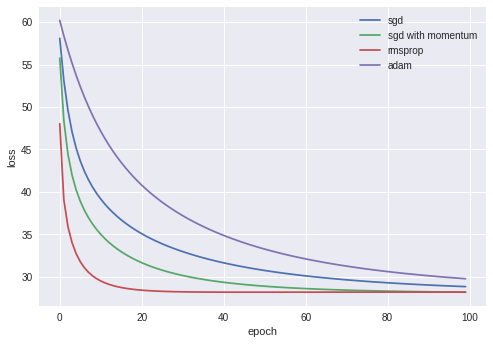

In [158]:
plt.ylabel('loss')
plt.xlabel('epoch')
legend_sgd, = plt.plot(loss_sgd, label='sgd')
legend_sgdmom, = plt.plot(loss_sgdmom, label='sgd with momentum')
legend_rms, = plt.plot(loss_rms, label='rmsprop')
legend_adam, = plt.plot(loss_adam, label='adam')
plt.legend(handles=[legend_sgd, legend_sgdmom, legend_rms, legend_adam])

## Exercise1: play with the hyperparameters of the optimizers and make training convergence faster




## Exercise2: train on the MNIST dataset

The MNIST dataset is available via the following code snippet. Build a small logistic regression model that trains on it using different optimization algorithms.

In [0]:
from torchvision import datasets, transforms
mnist_train = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

In [0]:
print("Size of MNIST training set: ", len(mnist_train))

In [0]:
# Example of getting a particular sample:
data, label = mnist_train[0]

In [0]:
print(data.shape)
print(label.item()) # label is a scalar